In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [2]:
df = pd.read_csv('/Users/billqiu/bootcamp_Zhiang_Qiu/project/data/raw/api_source-alpha_symbol-MSFT_20250820-142556.csv')

In [4]:
df.head()

,date,adj_close
0,2025-03-27,390.58
1,2025-03-28,378.80
2,2025-03-31,375.39
3,2025-04-01,382.19
4,2025-04-02,382.14


In [5]:
df['ret'] = df['adj_close'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,date,adj_close,ret,log_ret
0,2025-03-27,390.58,0.000000,0.000000
1,2025-03-28,378.80,-0.030160,-0.030624
2,2025-03-31,375.39,-0.009002,-0.009043
3,2025-04-01,382.19,0.018114,0.017952
4,2025-04-02,382.14,-0.000131,-0.000131


In [6]:
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# monthly rolling std
df['roll_std_21'] = df['log_ret'].rolling(21).std().shift(1)
# momentum
df['momentum'] = df['adj_close'] - df['adj_close'].shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,date,adj_close,ret,log_ret,lag_1,roll_mean_5,roll_std_21,momentum,y_next_ret,y_up
21,2025-04-28,391.16,-0.001761,-0.001762,0.011748,0.012952,0.029841,-0.69,0.007363,1
22,2025-04-29,394.04,0.007363,0.007336,-0.001761,0.017310,0.029844,2.88,0.003096,1
23,2025-04-30,395.26,0.003096,0.003091,0.007363,0.014494,0.029030,1.22,0.076254,1
24,2025-05-01,425.40,0.076254,0.073486,0.003096,0.010986,0.028923,30.14,0.023225,1
25,2025-05-02,435.28,0.023225,0.022960,0.076254,0.019340,0.032702,9.88,0.002045,1


In [7]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'roll_std_21', 'momentum']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.54      1.00      0.70         7

    accuracy                           0.62        16
   macro avg       0.77      0.67      0.60        16
weighted avg       0.80      0.62      0.59        16



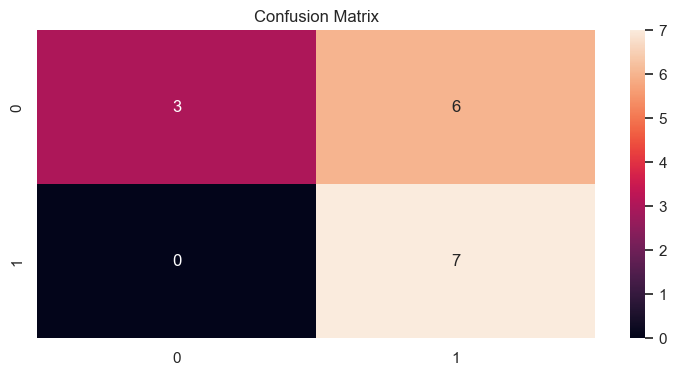

In [8]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

The following features are used:
1. lag1: The adjusted close price of the previous trading day.
2. roll_mean_5: The 5-period moving average of the return.
3. roll_std_21: The rolling standard deviation over the past 21 periods, which is a proxy of one month.
4. momentum: How the price changed in the past one day.

1 is a buy signal (positive next day return) and 0 is sell (negative next day return)

The model fails on mainly two parts:
1. half of the buy signals are actually false
2. it did not capture 2/3 of the down signals

The risk is that the model will invest when the market is actually going to go down.
However, overall, the model still has a 0.62 predicting accuracy, which means it is better than randomly guessing (0.5).

A potential next step is to size the positions, so that we can mitigate the negative effects.